In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error, r2_score
from imblearn.over_sampling import SMOTE

In [ ]:
data = pd.read_csv("/content/AirQualityUCI.csv", sep=';')
data = data.dropna(axis=1, how='all')

In [ ]:
for col in data.columns:
    if data[col].dtype == 'object':
        if data[col].str.contains(',', na=False).any():
            data[col] = data[col].str.replace(',', '.')
            data[col] = pd.to_numeric(data[col], errors='coerce')

In [ ]:
data.shape

(9471, 15)

In [ ]:
data.describe()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000
mean,-34.207524,1048.990061,-159.090093,1.865683,894.595276,168.616971,794.990168,58.148873,1391.479641,975.072032,9.778305,39.485380,-6.837604
std,77.657170,329.832710,139.789093,41.380206,342.333252,257.433866,321.993552,126.940455,467.210125,456.938184,43.203623,51.216145,38.976670
min,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000
25%,0.600000,921.000000,-200.000000,4.000000,711.000000,50.000000,637.000000,53.000000,1185.000000,700.000000,10.900000,34.100000,0.692300
50%,1.500000,1053.000000,-200.000000,7.900000,895.000000,141.000000,794.000000,96.000000,1446.000000,942.000000,17.200000,48.600000,0.976800
75%,2.600000,1221.000000,-200.000000,13.600000,1105.000000,284.000000,960.000000,133.000000,1662.000000,1255.000000,24.100000,61.900000,1.296200
max,11.900000,2040.000000,1189.000000,63.700000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,44.600000,88.700000,2.231000


In [ ]:
print(data.columns)

Index(['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)',
       'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
       'PT08.S5(O3)', 'T', 'RH', 'AH'],
      dtype='object')


In [ ]:
data.replace(-200, np.nan, inplace=True)

In [ ]:
data.drop(data[data['C6H6(GT)'].isnull()].index, axis = 0, inplace = True)

In [ ]:
data = data.drop(columns=['Date'])
data = data.drop(columns=['Time'])


Train and test split.

In [ ]:
train, test = train_test_split(data, test_size=0.2, random_state=42)

In [ ]:
X_train, y_train = train.drop('C6H6(GT)', axis=1), train['C6H6(GT)']
X_test, y_test = test.drop('C6H6(GT)', axis=1), test['C6H6(GT)']

In [ ]:
# Fill missing values in X_train using median values from X_train
to_fill = {column: np.nanmedian(X_train[column]) for column in X_train.columns}
X_train = X_train.fillna(value=to_fill)
X_test = X_test.fillna(value=to_fill)

Helper methods for evaluating model.

In [ ]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
    print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred)))
    print("Train R2:", r2_score(y_train, y_train_pred))
    print("Test R2:", r2_score(y_test, y_test_pred))

##Decision Tree Regressor

In [ ]:
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)
evaluate_model(dt, X_train, y_train, X_test, y_test)

Train RMSE: 2.513084535059055e-15
Test RMSE: 0.10405881947220988
Train R2: 1.0
Test R2: 0.9998115588454889


Visualize decision tree

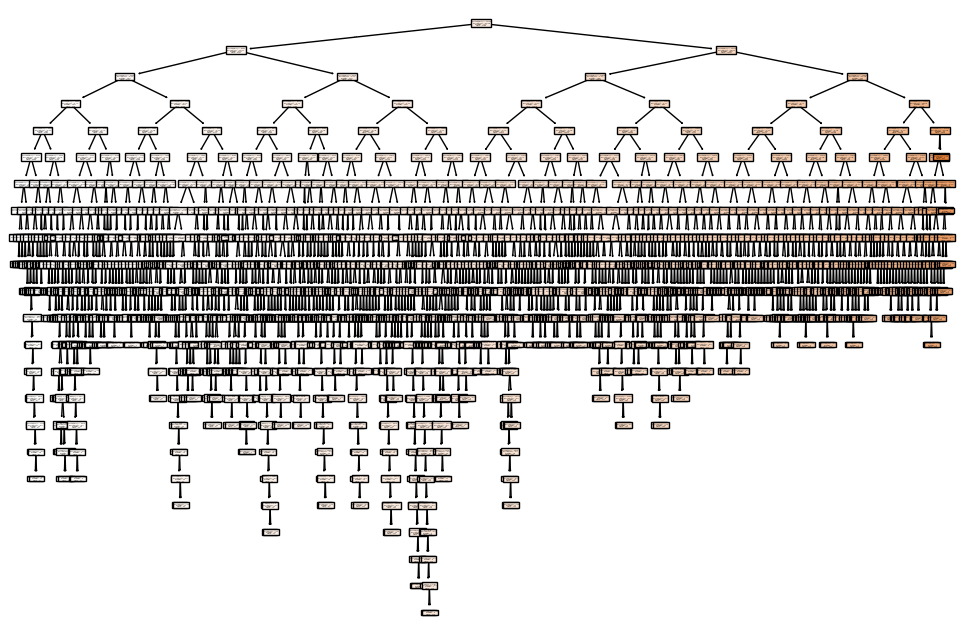

In [ ]:
plt.figure(figsize=(12, 8))
plot_tree(dt, feature_names=X_train.columns, filled=True)
plt.show()

Hyperparameter tuning for Decision Tree.

In [ ]:
dt_params = {'max_depth': [3, 5, 10, None], 'min_samples_split': [2, 5, 10]}
dt_grid = GridSearchCV(DecisionTreeRegressor(random_state=42), dt_params, cv=5, scoring='neg_mean_squared_error')
dt_grid.fit(X_train, y_train)
print("Best Decision Tree Params:", dt_grid.best_params_)

Best Decision Tree Params: {'max_depth': None, 'min_samples_split': 10}


##Random Forest Regressor

In [ ]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
evaluate_model(rf, X_train, y_train, X_test, y_test)

Train RMSE: 0.06607775634208256
Test RMSE: 0.12910060884442792
Train R2: 0.9999205604920579
Test R2: 0.9997099488791953


Hyperparameter tuning for Random Forest

In [ ]:
rf_params = {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, None], 'min_samples_split': [2, 5, 10]}
rf_grid = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, cv=5, scoring='neg_mean_squared_error')
rf_grid.fit(X_train, y_train)
print("Best Random Forest Params:", rf_grid.best_params_)

Best Random Forest Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}


Feature importance visualization for Random Forest

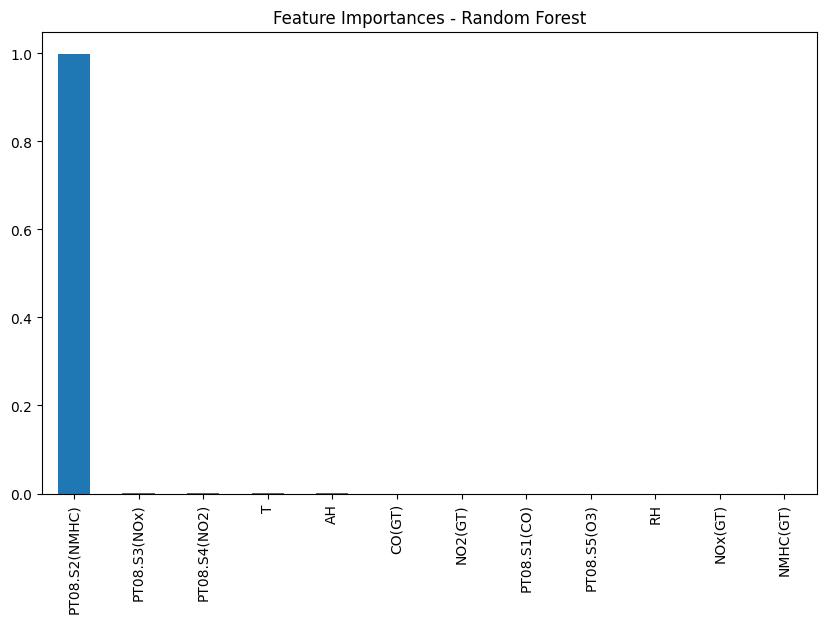

In [ ]:
rf_importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
rf_importances.plot(kind='bar')
plt.title("Feature Importances - Random Forest")
plt.show()

##XGBoost Regressor

In [ ]:
xgb = XGBRegressor(random_state=42, eval_metric='rmse')
xgb.fit(X_train, y_train)
evaluate_model(xgb, X_train, y_train, X_test, y_test)

Train RMSE: 0.031700676274080054
Test RMSE: 0.38658559530849174
Train R2: 0.9999817163447661
Test R2: 0.9973991859515857


Hyperparameter tuning for XGBoost

In [ ]:
xgb_params = {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 10], 'learning_rate': [0.01, 0.1, 0.3]}
xgb_grid = GridSearchCV(XGBRegressor(random_state=42), xgb_params, cv=5, scoring='neg_mean_squared_error')
xgb_grid.fit(X_train, y_train)
print("Best XGBoost Params:", xgb_grid.best_params_)

Best XGBoost Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}


Feature importance visualization for XGBoost

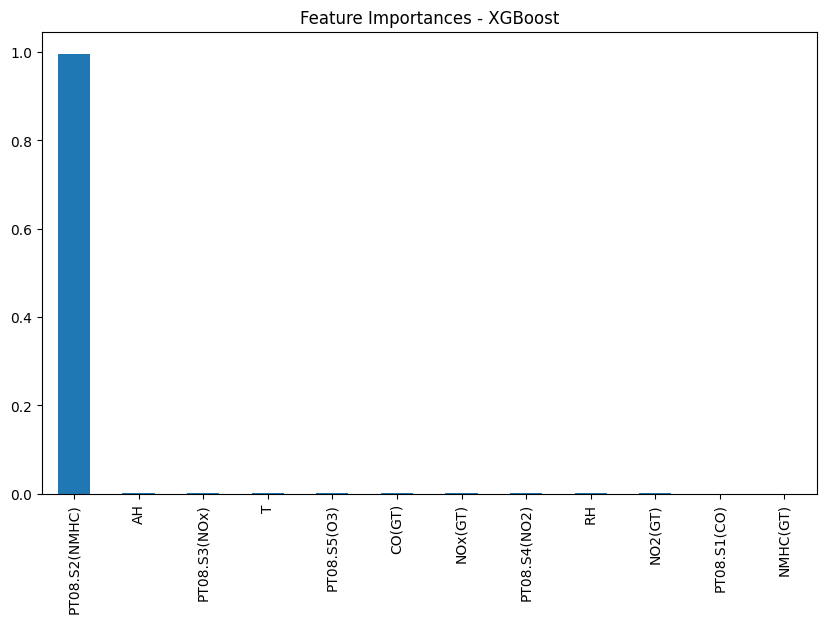

In [ ]:
xgb_importances = pd.Series(xgb.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
xgb_importances.plot(kind='bar')
plt.title("Feature Importances - XGBoost")
plt.show()

####Comparison of models

In [ ]:
models = ['Decision Tree', 'Random Forest', 'XGBoost']
train_rmse = [np.sqrt(mean_squared_error(y_train, dt.predict(X_train))),
              np.sqrt(mean_squared_error(y_train, rf.predict(X_train))),
              np.sqrt(mean_squared_error(y_train, xgb.predict(X_train)))]
test_rmse = [np.sqrt(mean_squared_error(y_test, dt.predict(X_test))),
             np.sqrt(mean_squared_error(y_test, rf.predict(X_test))),
             np.sqrt(mean_squared_error(y_test, xgb.predict(X_test)))]

comparison = pd.DataFrame({'Model': models, 'Train RMSE': train_rmse, 'Test RMSE': test_rmse})
print(comparison)

           Model    Train RMSE  Test RMSE
0  Decision Tree  2.513085e-15   0.104059
1  Random Forest  6.607776e-02   0.129101
2        XGBoost  3.170068e-02   0.386586


###Conclusion



The results at the training session were too good, there is a high chance that overfitting has occurred, we can avoid this by introducing more parameters for grid search and regularization for individual features for models.